## Real or Not? NLP with Disaster Tweets



This notebook is from **[Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)**. In this notebook, I show basic EDA, word2vector and light gbm to do a better prediction. Any comments are welcome and appreciated.

# Read dataset and EDA

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import nltk
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [30]:
train_df = pd.read_csv("Data/Train.csv")
test_df = pd.read_csv("Data/Test.csv")

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70000 non-null  object
 1   text    70000 non-null  object
 2   label   70000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [32]:
train_df.head(3)

ID                                               text  label
0  13P0QT0  3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...     -1
1  SKCLXCJ       cha3eb fey9elkoum menghir ta7ayoul ou kressi     -1
2  V1TVXIJ  bereau degage nathef ya slim walahi ya7chiw fi...     -1

In [33]:
print(train_df.shape)
print(test_df.shape)

(70000, 3)
(30000, 2)


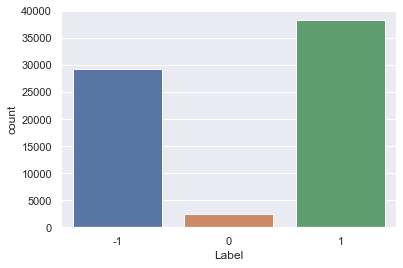

In [34]:
count_df = train_df.label.value_counts()
ax = sns.barplot(count_df.index, count_df)
ax.set(xlabel='Label', ylabel='count')
plt.show()

In [35]:
train_df['char'] = train_df['text'].str.len()
train_df['words'] = train_df['text'].str.split().map(lambda x: len(x))
train_df.head(3)

ID                                               text  label  char  \
0  13P0QT0  3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...     -1    84   
1  SKCLXCJ       cha3eb fey9elkoum menghir ta7ayoul ou kressi     -1    44   
2  V1TVXIJ  bereau degage nathef ya slim walahi ya7chiw fi...     -1   387   

   words  
0     10  
1      6  
2     64

In [36]:
fig=plt.figure(figsize=(16,6))

ax1=plt.subplot(1, 2, 1)
ax2=plt.subplot(1, 2, 2)

ax1.set_title('disaster tweet')
ax2.set_title('Not disaster tweet')

sns.distplot(train_df[train_df['label']==1]['char'], color='red', ax=ax1)
sns.distplot(train_df[train_df['label']==0]['char'], color='green', ax=ax2)

<AxesSubplot:title={'center':'Not disaster tweet'}, xlabel='char', ylabel='Density'>

<AxesSubplot:title={'center':'Not disaster tweet'}, xlabel='words', ylabel='Density'>

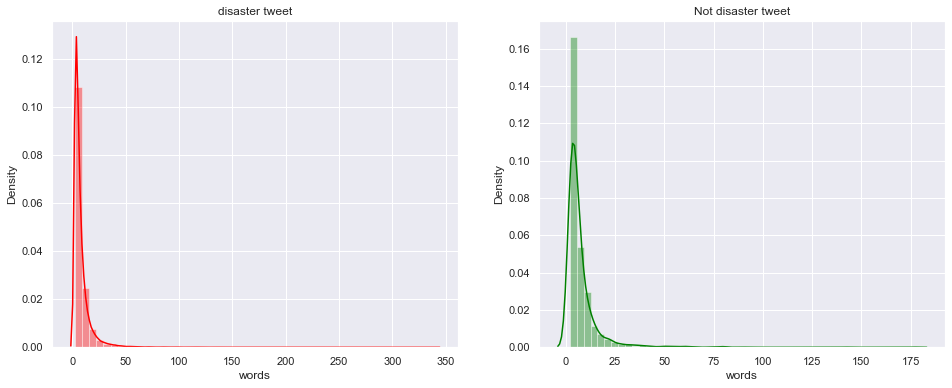

In [37]:
fig=plt.figure(figsize=(16,6))

ax1=plt.subplot(1, 2, 1)
ax2=plt.subplot(1, 2, 2)

ax1.set_title('disaster tweet')
ax2.set_title('Not disaster tweet')

sns.distplot(train_df[train_df['label']==1]['words'], color='red', ax=ax1)
sns.distplot(train_df[train_df['label']==0]['words'], color='green', ax=ax2)

<AxesSubplot:xlabel='words', ylabel='Density'>

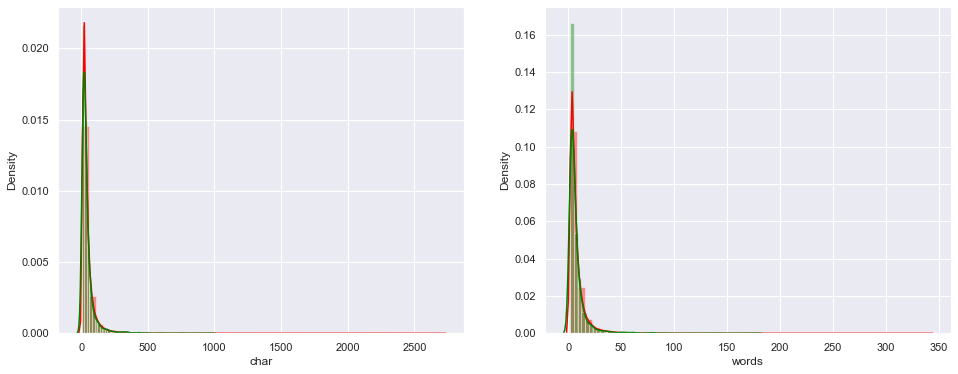

In [38]:
fig=plt.figure(figsize=(16,6))

ax1=plt.subplot(1, 2, 1)
ax2=plt.subplot(1, 2, 2)

sns.distplot(train_df[train_df['label']==1]['char'], color='red', ax=ax1)
sns.distplot(train_df[train_df['label']==0]['char'], color='green', ax=ax1)

sns.distplot(train_df[train_df['label']==1]['words'], color='red', ax=ax2)
sns.distplot(train_df[train_df['label']==0]['words'], color='green', ax=ax2)

# Remove URL

I remove URLs from tweets. I assume URLs would not help us make a better prediction.

In [39]:
train_df['text'] = train_df['text'].str.replace("http\S+", " ")
test_df['text'] = test_df['text'].str.replace("http\S+", " ")

# Mislabeled

There are 64 unique tweets that have the different label in duplicates. Those mislabeled tweets would lower our model accuracy. Let's remove those tweets and then build a model using identically labeled samples in training dataset.

In [40]:
train_df = train_df[['text', 'label']]
tweets = train_df.groupby('text').mean().reset_index()
print('There are {} tweets with different label in duplicates.'.format(tweets[(tweets['label']!=1) & (tweets['label']!=0)].shape[0]))
df_diff = tweets[(tweets['label']!=1) & (tweets['label']!=0)].reset_index(drop=True)
tweets = tweets[(tweets['label']==1) | (tweets['label']==0)].reset_index()

There are 29295 tweets with different label in duplicates.


In [41]:
# Show the mislabeled samples
for i in range(64):
    print(train_df[train_df['text']==df_diff.loc[i]['text']])

                                                    text  label
17003   en personne w zid mate9belch ena9d mbloukietn...     -1
                                                    text  label
61955   i purple you armyy rm jin suga j hope jimin v...     -1
                             text  label
6515   la 3ala9a b le mannequinat     -1
                                                    text  label
53023   mala 7ala walah ay 3abed 7our fech ya3eml na9...     -1
                             text  label
68983  -183 803 vues 8 juin 20-18     -1
                                   text  label
54402  0 04 makhyeeeebba el donc mte3ou     -1
                text  label
41507  0 09 masrou9a     -1
                                                    text  label
17425  0 17 7asestni tounes t7ebbek hhhh ya wallah 7w...     -1
                                                   text  label
5728  0 19 takreh zokek el 5amej ya neten taw entoum...     -1
                     text  label
37684  0 30 i m

# Building vectors and predicting models

The tutorial used `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Here I use word2vector to build vectors. A good tutorial is here **[Word Vectors](https://www.kaggle.com/matleonard/word-vectors)**.

In [48]:
# Load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
# We just want the vectors so we can turn off other models in the pipeline
with nlp.disable_pipes():
    vectors = np.array([nlp(tweet.text).vector for idx, tweet in tweets.iterrows()])
    
vectors.shape

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(vectors, tweets.target, test_size=0.2, 
                                                      random_state=52, stratify = tweets.target)


# Create the LinearSVC model
model = LinearSVC(random_state=1, dual=False)
# Fit the model
model.fit(X_train, y_train)

# Uncomment and run to see model accuracy
print(f'Model test accuracy: {model.score(X_valid, y_valid)*100:.3f}%')

In [ ]:
# 2nd models
from sklearn.linear_model import LogisticRegression

second_model = LogisticRegression(solver='saga')
second_model.fit(X_train, y_train)
print(f'Model test accuracy: {second_model.score(X_valid, y_valid)*100:.3f}%')

In [ ]:
# 3rd model
# from sklearn.linear_model import Ridge

third_model = linear_model.RidgeClassifier()
third_model.fit(X_train, y_train)

print(f'Model test accuracy: {third_model.score(X_valid, y_valid)*100:.3f}%')

In [ ]:
# create dataset for lightgbm
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# LightGBM parameters
params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : {'binary_logloss'},
    'num_leaves' : 51,
    'learning_rate' : 0.01,
    'max_bin': 397,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq': 5,
    'verbose' : 0
}

# train
gbm = lgb.train(params, lgb_train,
                valid_sets=[lgb_train, lgb_eval],
                verbose_eval=10,
                num_boost_round=1000,
                early_stopping_rounds=10)

y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

print(gbm.best_score['valid_1']['binary_logloss'])

fourth = pd.DataFrame([np.round(y_pred,0), y_valid], index=['y_pred', 'y_valid']).T
accuracy = fourth[fourth['y_pred']==fourth['y_valid']].shape[0]/fourth.shape[0]
print(f'Model test accuracy: {accuracy*100:.3f}%')

In [ ]:
from sklearn.metrics import f1_score

print('SVM f1 score {}'.format(f1_score(y_valid, np.round(model.predict(X_valid), 0).astype(int))))
print('Logistic Regression f1 score {}'.format(f1_score(y_valid, np.round(second_model.predict(X_valid), 0).astype(int))))
print('Ridge Classifier f1 score {}'.format(f1_score(y_valid, np.round(third_model.predict(X_valid), 0).astype(int))))
print('Light GBM f1 score {}'.format(f1_score(y_valid, np.round(gbm.predict(X_valid, num_iteration=gbm.best_iteration), 0).astype(int))))

Light gbm has the best predicting power for this dataset.

# Cross Validation

In [ ]:
# apply same word vectors building to test data
with nlp.disable_pipes():
    vectors_pred = np.array([nlp(tweet.text).vector for idx, tweet in test_df.iterrows()])
    
vectors_pred.shape

In [ ]:
from sklearn.model_selection import KFold

X_train = pd.DataFrame(vectors)
y_train = tweets['label']
X_test = pd.DataFrame(vectors_pred)

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=100892)

params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'binary',
        'metric' : {'binary_logloss'},
        'num_leaves' : 51,
        'max_bin' : 397,
        'learning_rate' : 0.01,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : 0
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[valid_index]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                     valid_sets=[lgb_train, lgb_eval],
                     verbose_eval=10,
                     num_boost_round=1000,
                     early_stopping_rounds=10)
    
    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    y_preds.append(y_pred)
    models.append(model)

scores = [
    m.best_score['valid_1']['binary_logloss'] for m in models
]
score = sum(scores) / len(scores)

In [ ]:
print('===CV scores===')
print(scores)
print(score)

In [ ]:
pred = pd.DataFrame(np.round(y_preds, 0)).astype('int8').T

In [ ]:
np.round(pred.mean(axis=1),0).astype(int)

# Hyperparameter tuning LGBM

Since it takes time to run the auto hyperparameter tuning below, I changed the to comments. The result reflected above.

In [ ]:
# import optuna
# from sklearn.metrics import log_loss

# def objective(trial):
#     params = {
#         'objective': 'regression',
#         'metric' : {'binary_logloss'},
#         'num_leaves': trial.suggest_int('num_leaves', 32, 128),
#         'learning_rate': 0.01,
#         'max_bin': trial.suggest_int('max_bin', 255, 500)
#     }
    
#     lgb_train = lgb.Dataset(X_train, y_train)
    
#     lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
#     model = lgb.train(params, lgb_train,
#                      valid_sets=[lgb_train, lgb_eval],
#                      verbose_eval=10,
#                      num_boost_round=1000,
#                      early_stopping_rounds=10)
    
#     y_pred_valid = model.predict(X_test,
#                                 num_iteration=model.best_iteration)
#     score = log_loss(y_test, y_pred_valid)
#     return score

# study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
# study.optimize(objective, n_trials=40)
# study.best_params

### Our model

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission

In [ ]:
sample_submission["label"] = np.round(pred.mean(axis=1),0).astype(int)
sample_submission["label"] = sample_submission["label"].astype('int8')

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv("Submissions/submissionlgbm.csv", index=False)

# TODO

* Data cleaning: Relabel mislabeled samples and Cleaning puctuation
* Bulding better word vectors
* Use keyword column to predict
* Neural network model